**Music genre prediction**

Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.


Описание полей данных:

instance_id - уникальный идентификатор трека
track_name - название трека
acousticness - акустичность
danceability - танцевальность
duration_ms -продолжительность в милисекундах
energy - энергичность
instrumentalness - инструментальность
key - базовый ключ (нота) произведения
liveness - привлекательность
loudness - громкость
mode - указывает на модальность (мажорную или минорную) трека
speechiness - выразительность
tempo - темп
obtained_date - дата загрузки в сервис
valence - привлекательность произведения для пользователей сервиса
music_genre - музыкальный жанр

В качестве исходных данных представлены два файла kaggle_music_genre_train.csv и kaggle_music_genre_test.csv с обучающими и тестовыми данными. В тестовом файле kaggle_music_genre_test.csv столбец music_genre с целевым показателем отсутствует.

Метрика для оценки качества работы модели - F1_micro.

Загружаем дополнительные библиотеки, которые нам упростят работу.

In [ ]:
pip install feature-engine

In [ ]:
pip install phik

In [ ]:
pip install catboost

Импорт библиотек и инструментов для работы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import phik

from phik.report import plot_correlation_matrix
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

**Загрузка и изучение данных:**

In [ ]:
train = pd.read_csv('/content/kaggle_music_genre_train.csv')
test = pd.read_csv('/content/kaggle_music_genre_test.csv')
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [ ]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [ ]:
train['music_genre'].value_counts()

Blues          2858
Alternative    2601
Electronic     2564
Rap            2428
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

<Axes: xlabel='music_genre', ylabel='count'>

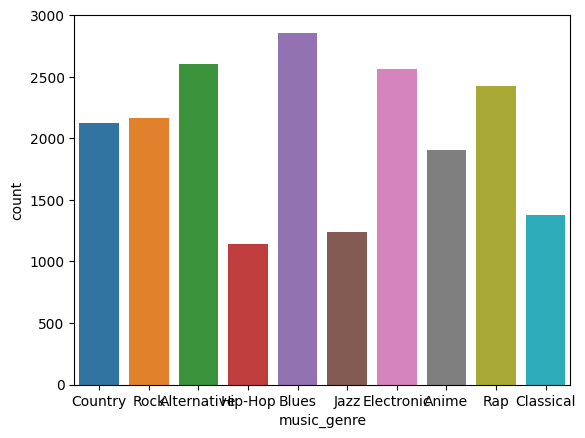

In [ ]:
sns.countplot(data= train, x="music_genre")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


Вывод:
1. Из получанной информации видно, что в обоих датафреймах имеются пропуска в столбцах key, mode и tempo.
2. Целевой признак - music_genre, имеет 10 жанров.

Анализ исходных данных.

In [ ]:
train.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


In [ ]:
test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


In [ ]:
train.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

In [ ]:
for column in train.columns:
    print(column)
    print(train[column].sort_values().unique())

instance_id
[20011. 20016. 20017. ... 91749. 91757. 91758.]
track_name
['"99"'
 '"Christen, ätzet diesen Tag", BWV 63: I. Choral "Christen, ätzet diesen Tag"'
 '"Concerto Funebre" con hautbois sordini e salmoè, violino principale e viole da gamba (Si Bem. Maggiore, RV 579): II. Allegro poco poco'
 ... '鶏と蛇と豚' '黒い弾丸' '黒い雫']
acousticness
[0.00e+00 1.02e-06 1.27e-06 ... 9.94e-01 9.95e-01 9.96e-01]
danceability
[0.06   0.0602 0.0606 0.0607 0.061  0.0614 0.0616 0.0618 0.0623 0.0624
 0.0628 0.063  0.0631 0.0637 0.0639 0.0644 0.0645 0.0646 0.065  0.0651
 0.0656 0.066  0.0662 0.0663 0.0666 0.0667 0.0676 0.0677 0.0686 0.0691
 0.0695 0.0699 0.0701 0.0708 0.0715 0.0716 0.0728 0.074  0.0744 0.0745
 0.0747 0.0753 0.0764 0.0765 0.0769 0.0775 0.0783 0.0786 0.0787 0.0789
 0.079  0.0792 0.08   0.0809 0.0816 0.0818 0.0819 0.0822 0.0828 0.0829
 0.0831 0.0832 0.0833 0.0836 0.0843 0.0845 0.085  0.0859 0.0863 0.0865
 0.0866 0.0869 0.0873 0.0877 0.0882 0.0888 0.0896 0.0906 0.093  0.0932
 0.0937 0.0942 0.0949

In [ ]:
for column in test.columns:
    print(column)
    print(test[column].sort_values().unique())

instance_id
[20012 20031 20040 ... 91677 91686 91709]
track_name
['#NAME?' '#Sádico' "'39 - Remastered 2011" ...
 '風に乗れ 進研ゼミCM ORIGINAL COVER INST.Ver' '風の伝説' '骸Attack!!']
acousticness
[2.36e-06 3.23e-06 4.68e-06 ... 9.94e-01 9.95e-01 9.96e-01]
danceability
[0.0596 0.0607 0.0618 0.0642 0.0652 0.0665 0.0677 0.069  0.0696 0.0707
 0.0742 0.0754 0.0772 0.0773 0.0783 0.0798 0.0811 0.0839 0.0845 0.0846
 0.0856 0.086  0.0873 0.0906 0.092  0.0935 0.0936 0.0969 0.1    0.104
 0.106  0.107  0.108  0.109  0.112  0.113  0.115  0.119  0.122  0.124
 0.126  0.127  0.129  0.13   0.133  0.141  0.142  0.143  0.144  0.145
 0.146  0.147  0.148  0.15   0.151  0.153  0.154  0.155  0.156  0.157
 0.158  0.159  0.161  0.162  0.163  0.166  0.167  0.168  0.169  0.17
 0.171  0.173  0.174  0.175  0.176  0.177  0.179  0.18   0.182  0.183
 0.184  0.185  0.186  0.187  0.189  0.19   0.192  0.194  0.196  0.197
 0.198  0.199  0.201  0.202  0.203  0.204  0.205  0.206  0.207  0.208
 0.209  0.21   0.212  0.213  0.214  0.215

In [ ]:
train['duration_ms'].sort_values().unique()

array([-1.000000e+00,  1.550900e+04,  1.631600e+04, ...,  2.764934e+06,
        4.276000e+06,  4.497994e+06])

In [ ]:
train['duration_ms'] = train['duration_ms'].replace( -1, np.NaN)

In [ ]:
train['duration_ms'] = train.duration_ms.fillna(train.groupby('music_genre').duration_ms.transform('median'))

In [ ]:
train['duration_ms'].isna().sum()

0

In [ ]:
test['duration_ms'] = test['duration_ms'].replace( -1, np.NaN)
test['duration_ms'] = test['duration_ms'].replace(np.NaN, test['duration_ms'].median())
test['duration_ms'].isna().sum()

0

In [ ]:
train[['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
       'music_genre']].duplicated().sum()

1

In [ ]:
train = train.drop_duplicates(subset=['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date', 'valence',
       'music_genre']).reset_index(drop=True)

Text(0.5, 1.0, 'Распределение данных столбца music_genre')

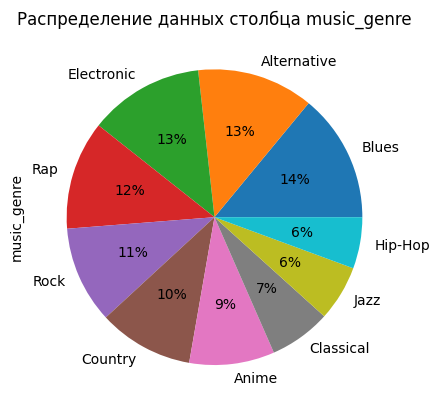

In [ ]:
train['music_genre'].value_counts().plot.pie(autopct='%1.0f%%').set_title('Распределение данных столбца music_genre')

In [ ]:
train.groupby(by='music_genre').median()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
music_genre,,,,,,,,,,,
Alternative,56307.0,0.03160,0.5450,225725.5,0.750,0.000066,0.135,-6.0350,0.0535,120.0480,0.434
Anime,55109.0,0.05190,0.4830,239523.0,0.798,0.000258,0.139,-5.6190,0.0456,128.0020,0.435
Blues,55929.0,0.21050,0.5290,228827.0,0.635,0.000971,0.141,-8.4175,0.0434,119.1180,0.586
Classical,56579.0,0.96900,0.2960,263373.0,0.100,0.837000,0.111,-21.9570,0.0432,95.5235,0.139
Country,56902.0,0.19050,0.5815,211705.5,0.668,0.000001,0.129,-6.4990,0.0341,121.9700,0.531
Electronic,56283.0,0.02640,0.6310,243629.0,0.771,0.178000,0.127,-6.4040,0.0572,125.9995,0.361
Hip-Hop,55954.0,0.10500,0.7380,212854.5,0.652,0.000000,0.137,-6.5830,0.1960,120.1000,0.465
Jazz,55894.0,0.51600,0.5960,247400.0,0.472,0.135000,0.116,-10.4000,0.0438,105.3485,0.517
Rap,54911.5,0.09605,0.7190,214307.0,0.650,0.000000,0.135,-6.3385,0.1620,120.0200,0.449


In [ ]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

In [ ]:
test['key'].unique()

array(['A#', 'G#', 'A', 'B', 'D', 'F#', 'F', 'G', 'C', nan, 'D#', 'C#',
       'E'], dtype=object)

Text(0.5, 1.0, 'Распределение данных столбца key')

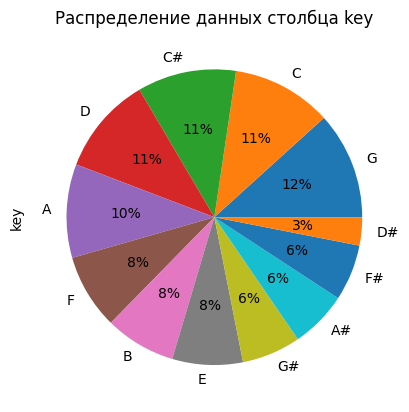

In [ ]:
train['key'].value_counts().plot.pie(autopct='%1.0f%%').set_title('Распределение данных столбца key')

Text(0.5, 1.0, 'Распределение данных столбца key')

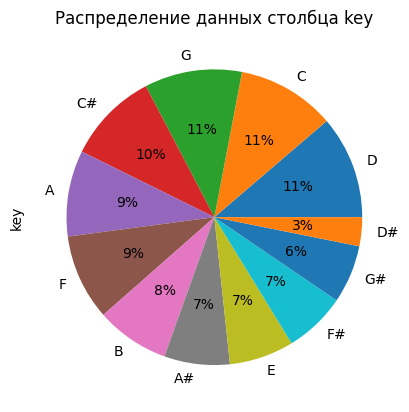

In [ ]:
test['key'].value_counts().plot.pie(autopct='%1.0f%%').set_title('Распределение данных столбца key')

In [ ]:
train['mode'].unique()

array(['Major', 'Minor', nan], dtype=object)

In [ ]:
test['mode'].unique()

array(['Minor', 'Major', nan], dtype=object)

In [ ]:
train['obtained_date'].value_counts(normalize=True)

4-Apr    0.903938
3-Apr    0.074732
5-Apr    0.014221
1-Apr    0.007110
Name: obtained_date, dtype: float64

In [ ]:
test['obtained_date'].value_counts(normalize=True)

4-Apr    0.901549
3-Apr    0.077466
5-Apr    0.012748
1-Apr    0.008237
Name: obtained_date, dtype: float64

<Axes: >

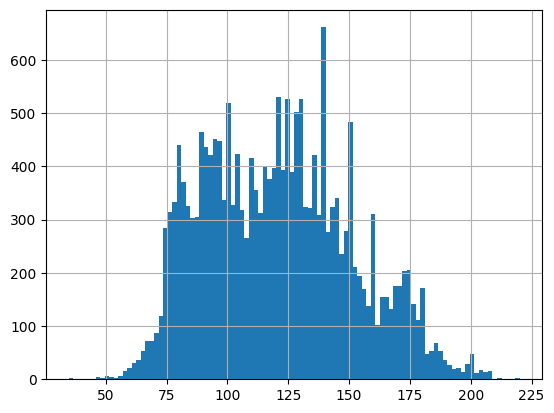

In [ ]:
train['tempo'].hist(bins=100)

<Axes: >

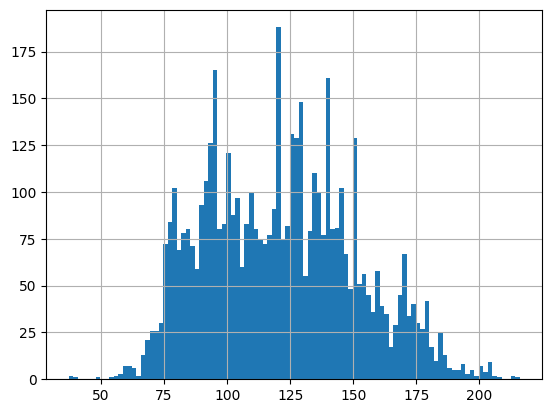

In [ ]:
test['tempo'].hist(bins=100)

In [ ]:
train['tempo'].describe()

count    19951.000000
mean       120.941985
std         30.428258
min         34.765000
25%         95.921500
50%        120.012000
75%        141.966500
max        220.041000
Name: tempo, dtype: float64

In [ ]:
test['tempo'].describe()

count    4978.000000
mean      121.246463
std        29.875950
min        37.114000
25%        96.070250
50%       120.053500
75%       141.934250
max       216.029000
Name: tempo, dtype: float64

In [ ]:
df_train = train.dropna()
df_train.shape

(18753, 16)

In [ ]:
df_test = test
df_test.shape

(5099, 15)

Обработка датафреймов.

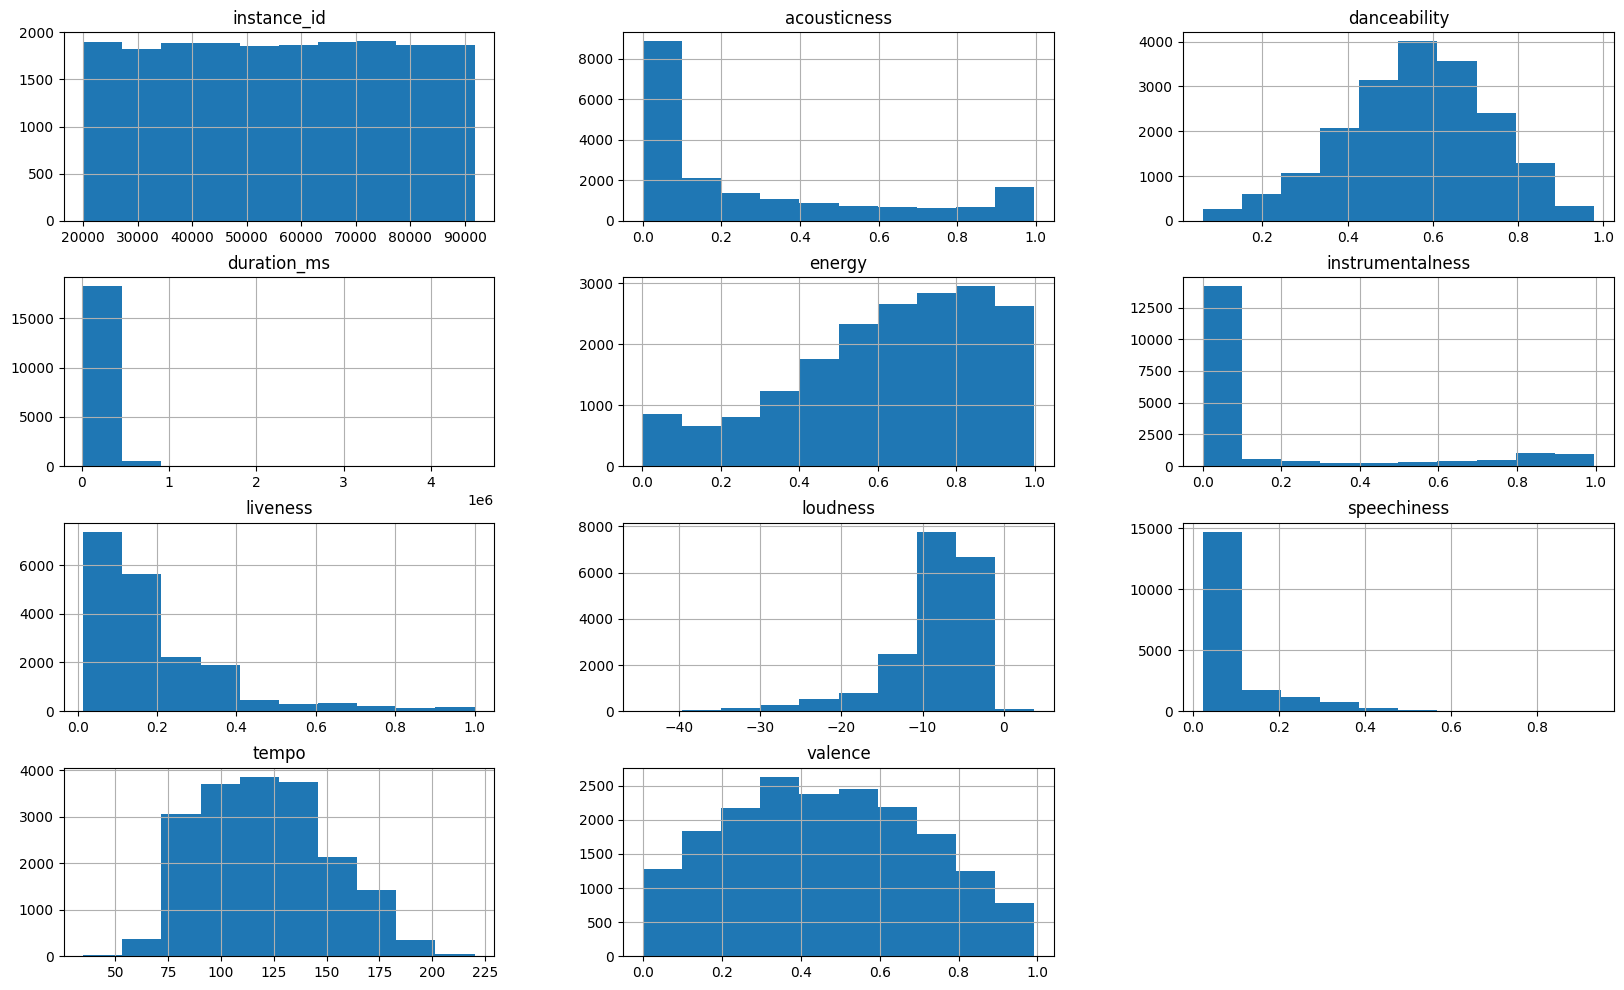

In [ ]:
df_train.hist(figsize=(20, 12));

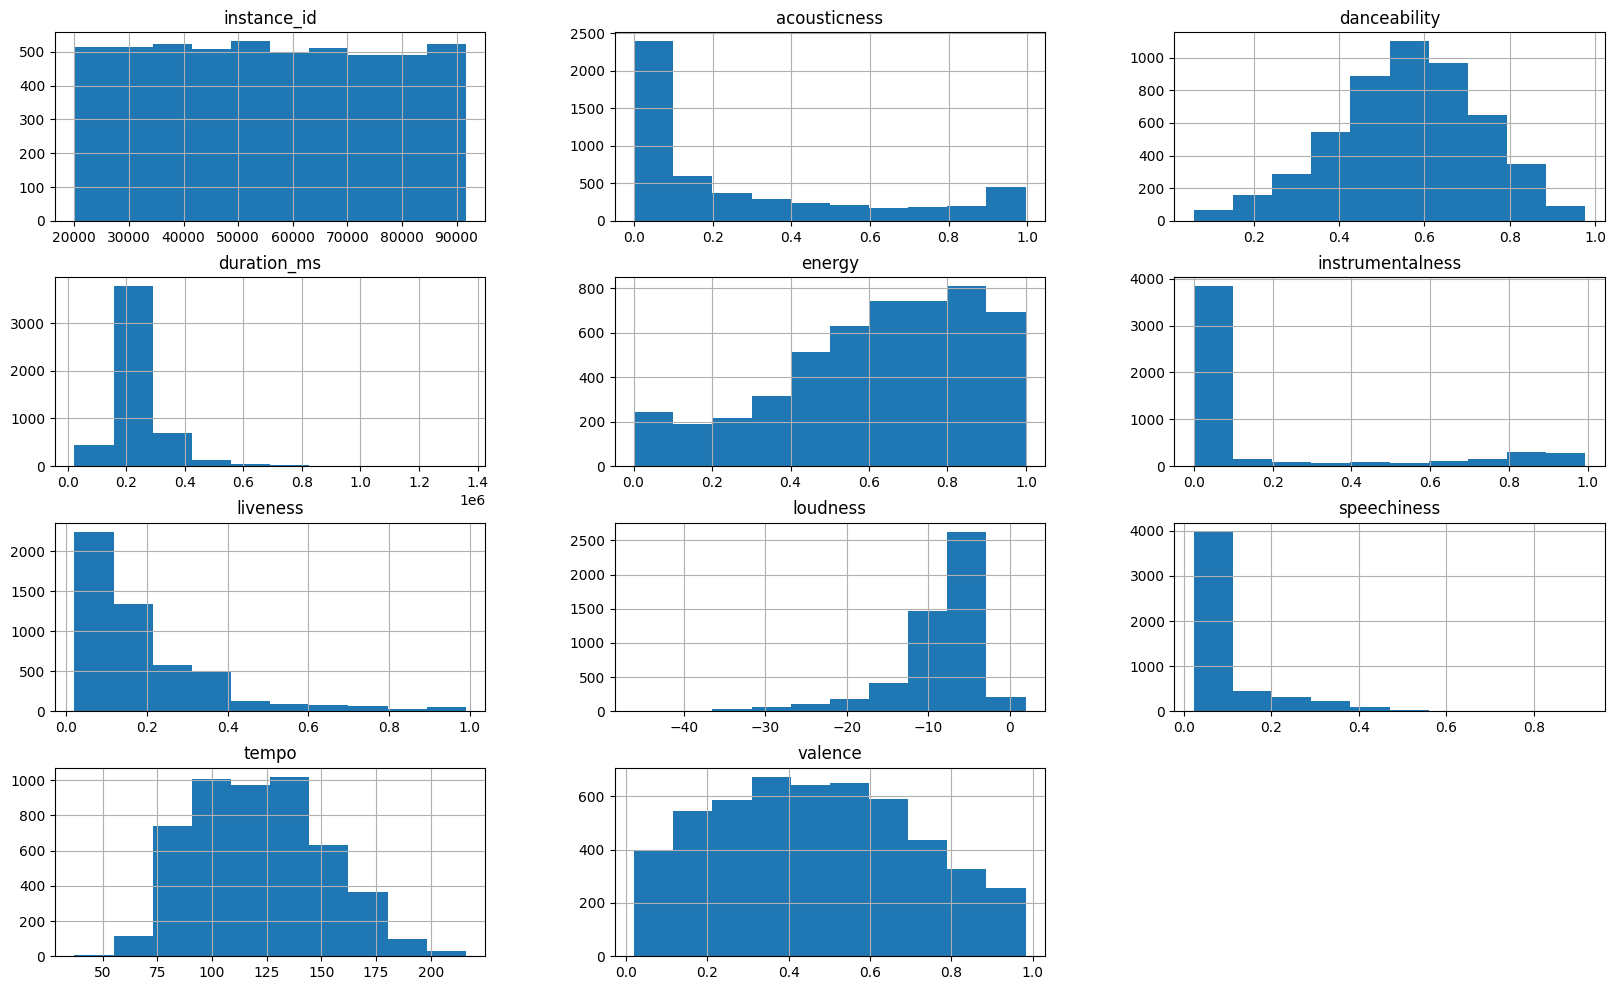

In [ ]:
df_test.hist(figsize=(20, 12));

In [ ]:
pd.concat([df_train['key'], df_test['key']]).value_counts()

G     2725
C     2582
D     2578
C#    2517
A     2379
F     2003
B     1845
E     1792
G#    1529
A#    1528
F#    1478
D#     738
Name: key, dtype: int64

In [ ]:
df_test['key'] = df_test['key'].fillna('G')

In [ ]:
pd.concat([df_train['mode'], df_test['mode']]).value_counts(normalize=True)

Major    0.645024
Minor    0.354976
Name: mode, dtype: float64

In [ ]:
df_test['mode'] = df_test['mode'].fillna('Major')

In [ ]:
df_test['tempo'] = df_test['tempo'].fillna(df_test['tempo'].median())

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18753 entries, 0 to 20392
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       18753 non-null  float64
 1   track_name        18753 non-null  object 
 2   acousticness      18753 non-null  float64
 3   danceability      18753 non-null  float64
 4   duration_ms       18753 non-null  float64
 5   energy            18753 non-null  float64
 6   instrumentalness  18753 non-null  float64
 7   key               18753 non-null  object 
 8   liveness          18753 non-null  float64
 9   loudness          18753 non-null  float64
 10  mode              18753 non-null  object 
 11  speechiness       18753 non-null  float64
 12  tempo             18753 non-null  float64
 13  obtained_date     18753 non-null  object 
 14  valence           18753 non-null  float64
 15  music_genre       18753 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               5099 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              5099 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             5099 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


Вывод:
1. Выполнили удаление дублката только из тренировочного датафрейма.
2. Пропуски удалили из тренировочного датафрейма, а в тестовом заполнили близкими значениями.
3. Аномальные значения в столбце duration_ms обоих датафреймов заменены медианными значениями.

Анализ корреляции с помощью библиотеки Phik.

In [ ]:
data = df_train.phik_matrix()

interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


In [ ]:
print (data)

                  instance_id  track_name  acousticness  danceability  \
instance_id          1.000000    0.000000      0.019521      0.026751   
track_name           0.000000    1.000000      0.941608      0.959230   
acousticness         0.019521    0.941608      1.000000      0.458398   
danceability         0.026751    0.959230      0.458398      1.000000   
duration_ms          0.029162    0.986062      0.142045      0.180084   
energy               0.000000    0.945584      0.766572      0.515222   
instrumentalness     0.000000    0.957632      0.442582      0.339888   
key                  0.008638    0.938738      0.096920      0.103162   
liveness             0.018029    0.940696      0.188635      0.132878   
loudness             0.000000    0.977003      0.710157      0.480080   
mode                 0.015319    0.785946      0.026325      0.100593   
speechiness          0.000000    0.930866      0.207590      0.336211   
tempo                0.000000    0.954836      0.33

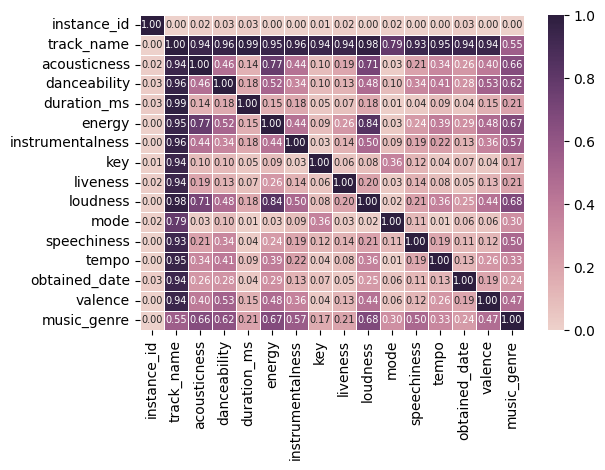

In [ ]:
sns.heatmap(data,
                        vmin=0, vmax=1,
                    annot = True,
                annot_kws = {"size":7},
                cmap=sns.cubehelix_palette(as_cmap=True),
                fmt='.2f',  linewidth=.5)
plt.tight_layout()

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


<Axes: >

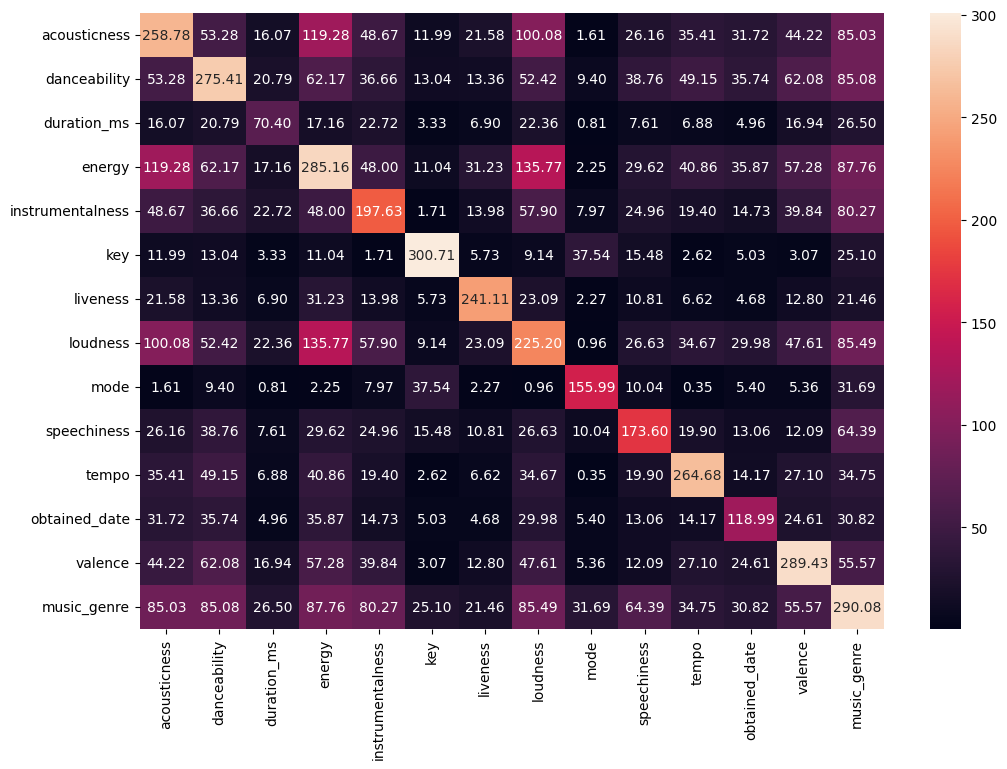

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_train[['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness',
                      'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date',
                      'valence', 'music_genre']].significance_matrix(),
            annot=True, fmt=".2f")

In [ ]:
df1, df2 = df_train[['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness',
                      'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'obtained_date',
                      'valence', 'music_genre']].global_phik()

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


<Axes: >

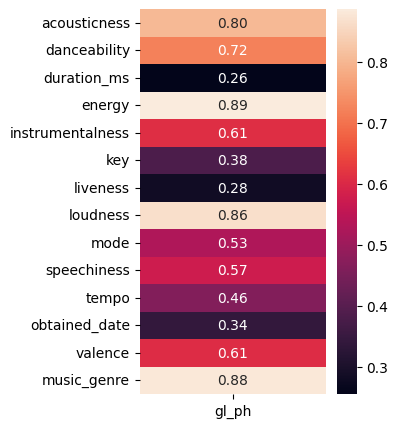

In [ ]:
df = pd.DataFrame(df1, columns = ['gl_ph'])
df.index = df2
plt.figure(figsize=(3,5))
sns.heatmap(df, annot=True, fmt=".2f")

Вывод:
1. Видно корреляцию данных трёх столбцов датафреймов energy, loudness и acousticness. Однако, так как коэффициенты их корреляцые не близки 1 все три столбца будем использовать в качестве обучающих признаков.
2. Признаки утечек по таргету не найдены.

In [ ]:
df_train = df_train.drop(['track_name'], axis= 1)

Создание данных с обучающими и целевыми признаками.

**1. Модель дерево решения**

In [ ]:
X = df_train.drop('music_genre', axis=1)
y = df_train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [ ]:
features_train = df_train[num_cols]
target_train = df_train['music_genre']

In [ ]:
model_tree = DecisionTreeClassifier(random_state=12345)

In [ ]:
param_grid_tree = {       "max_depth" : list(range(1,15,1)),
                   "min_samples_leaf" : list(range(1,5,1)),
                  "min_samples_split" : list(range(2,5,1))}

In [ ]:
grid_search_tree = GridSearchCV(model_tree, param_grid_tree, scoring=make_scorer(f1_score, average='micro'), n_jobs=-1)

In [ ]:
%%time
grid_search_tree.fit(features_train, target_train)

CPU times: user 6.23 s, sys: 539 ms, total: 6.77 s
Wall time: 2min 18s


GridSearchCV(estimator=DecisionTreeClassifier(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4]},
             scoring=make_scorer(f1_score, average=micro))

In [ ]:
grid_search_tree.best_params_

{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [ ]:
grid_search_tree.best_score_

0.4164134435261708

In [ ]:
model_tree = DecisionTreeClassifier(**grid_search_tree.best_params_, random_state=12345)

In [ ]:
model_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=9, min_samples_split=4, random_state=12345)

**Используем инструмент Pipeline**

In [ ]:
num_pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('dr_correl_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('dr_const_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

**2. Модель случайный лес.**



In [ ]:
rfc = RandomForestClassifier()

pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', rfc)
])

param_dist = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [5, 10]
}

grid = RandomizedSearchCV(pipeline,
                    param_dist,
                    n_iter=30,
                    cv=3,
                    verbose=5,
                    random_state=12345,
                    scoring='f1_micro',
                    n_jobs=-1)

In [ ]:
%%time
grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
CPU times: user 35.6 s, sys: 294 ms, total: 35.9 s
Wall time: 2min 29s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pipeline',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_pipeline',
                                                                               Pipeline(steps=[('scaler',
                                                                                                RobustScaler()),
                                                                                               ('dr_correl_features',
                                                                                                DropCorrelatedFeatures()),
                                                                                               ('polynomial_features',
                                                                                                PolynomialFeatures()),
                                                                                               ('dr_const_features',
                                                                                                DropConstantFeatures(tol=0.998))]),
                                                                               ['instance_id',
                                                                                'acousticn...
                                                                                'tempo',
                                                                                'valence']),
                                                                              ('cat_pipeline',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['key',
                                                                                'mode',
                                                                                'obtained_date'])])),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10],
                                        'model__n_estimators': [100, 300]},
                   random_state=12345, scoring='f1_micro', verbose=5)

In [ ]:
grid.best_params_

{'model__n_estimators': 300, 'model__max_depth': 10}

In [ ]:
predicted = grid.predict(X_test)
f1_score(y_test, predicted, average='micro').round(2)

0.46

**3. Модель градиентный бустинг.**

In [ ]:
cbc = CatBoostClassifier(
    thread_count=4,
    random_strength=1,
    max_ctr_complexity=1,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=300,
    early_stopping_rounds=10,
    depth=5,
    border_count=10,
    bootstrap_type='Bayesian'
)

cbc_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

cbc_pipeline.fit(X_train, y_train)
y_pred = cbc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

0:	learn: 2.2031388	total: 90.3ms	remaining: 27s
1:	learn: 2.1283516	total: 129ms	remaining: 19.2s
2:	learn: 2.0605147	total: 177ms	remaining: 17.5s
3:	learn: 2.0031493	total: 228ms	remaining: 16.9s
4:	learn: 1.9571082	total: 272ms	remaining: 16s
5:	learn: 1.9187916	total: 329ms	remaining: 16.1s
6:	learn: 1.8839160	total: 375ms	remaining: 15.7s
7:	learn: 1.8586983	total: 419ms	remaining: 15.3s
8:	learn: 1.8299112	total: 476ms	remaining: 15.4s
9:	learn: 1.8053110	total: 520ms	remaining: 15.1s
10:	learn: 1.7884426	total: 562ms	remaining: 14.8s
11:	learn: 1.7677632	total: 604ms	remaining: 14.5s
12:	learn: 1.7473742	total: 648ms	remaining: 14.3s
13:	learn: 1.7296344	total: 693ms	remaining: 14.2s
14:	learn: 1.7142463	total: 748ms	remaining: 14.2s
15:	learn: 1.6967534	total: 812ms	remaining: 14.4s
16:	learn: 1.6848249	total: 851ms	remaining: 14.2s
17:	learn: 1.6756585	total: 892ms	remaining: 14s
18:	learn: 1.6602612	total: 959ms	remaining: 14.2s
19:	learn: 1.6478991	total: 1s	remaining: 14.1

Проводим анализ важности признаков.

In [ ]:
results_importance = permutation_importance(model_tree, features_train, target_train, scoring=make_scorer(f1_score, average='micro'))

In [ ]:
importance = results_importance.importances_mean

<Axes: >

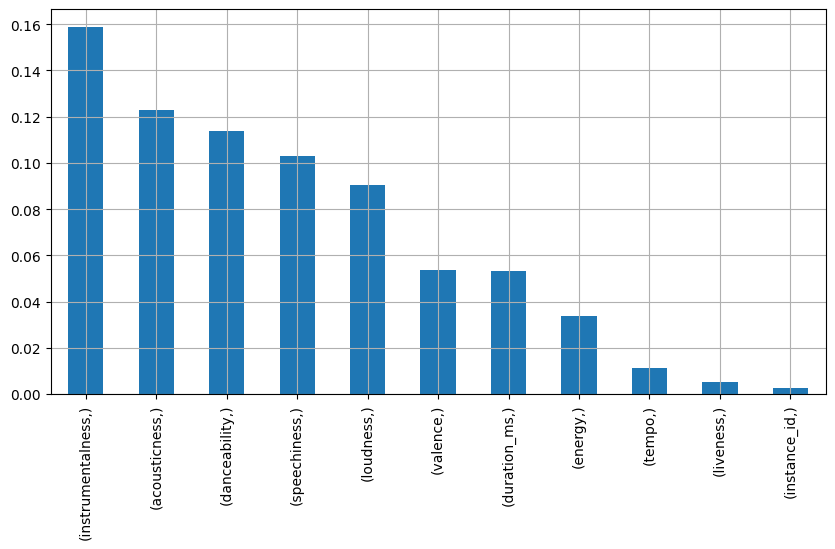

In [ ]:
pd.Series(importance, index=[num_cols]).sort_values(ascending=False).plot(kind="bar", figsize=(10,5), grid=True)

Вывод:
Таким образом, на основе полученных данных можно утверждать, что наиболее важным параметром, влияющим на оценку жанра музыки является инструментальность трека (instrumentalness).

**Общий вывод:**

По результатам выполненной работы разработаны три модели, которые имеют следующие показатели качества f1:

Модель дерева решений - 0.42;

Модель случайного леса - 0,46;

Модель градиентный бустинг catboost - 0,49.

Таким образом, наилучшей моделью является CatBoostClassifier, построенная с помощью инструмента catboost.

Проводим проверку лучшей модели CatBoostClassifier на тесте и загружаем ответ.



In [ ]:
predicted = cbc_pipeline.predict(df_test)

In [ ]:
predictions = pd.DataFrame()
predictions = test
predictions['music_genre'] = np.array(predicted)
predictions = predictions[['instance_id','music_genre']]
predictions.to_csv('submission20.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
tr = pd.read_csv('/content/submission20.csv')

tr.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Rock
2,88081,Rap
3,78331,Country
4,72636,Alternative
